In [2]:
import os
import time
import ccxt
import pandas as pd
from datetime import datetime, timedelta, timezone
from dotenv import load_dotenv

load_dotenv()

def fetch_kraken_ohlcv(symbol="BTC/USD", timeframe="1h", lookback_days=30, limit_per_fetch=720, pause=1.2):
    """
    Fetch OHLCV price data from Kraken for a given symbol and lookback period.
    
    Args:
        symbol (str): Kraken trading pair (e.g., "BTC/USD", "ETH/USD")
        timeframe (str): OHLCV timeframe (e.g., '1h', '1d')
        lookback_days (int): How many days of data to fetch
        limit_per_fetch (int): Max candles per API call
        pause (float): Delay between calls to avoid rate limits

    Returns:
        pd.DataFrame: OHLCV dataframe with timestamp index
    """
    kraken = ccxt.kraken({
        'apiKey': os.getenv("KRAKEN_API_KEY"),
        'secret': os.getenv("KRAKEN_API_SECRET"),
        'enableRateLimit': True,
    })

    end_time = datetime.now(timezone.utc)
    start_time = end_time - timedelta(days=lookback_days)
    since = int(start_time.timestamp() * 1000)

    all_ohlcv = []

    print(f"⏳ Fetching last {lookback_days} days of {symbol} ({timeframe}) data...")

    while True:
        try:
            ohlcv = kraken.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit_per_fetch)
            if not ohlcv:
                break
            all_ohlcv.extend(ohlcv)
            print(f"✅ Got {len(ohlcv)} candles — latest: {pd.to_datetime(ohlcv[-1][0], unit='ms')}")
            since = ohlcv[-1][0] + 1
            if pd.to_datetime(ohlcv[-1][0], unit='ms') >= end_time:
                break
            time.sleep(pause)
        except Exception as e:
            print(f"⚠️ Error: {e}. Retrying...")
            time.sleep(5)

    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

    print(f"✅ Fetched {len(df)} rows for {symbol}")
    return df


df_btc = fetch_kraken_ohlcv("BTC/USD")
df_eth = fetch_kraken_ohlcv("ETH/USD")


⏳ Fetching last 30 days of BTC/USD (1h) data...
✅ Got 720 candles — latest: 2025-05-01 01:00:00
⚠️ Error: can't compare offset-naive and offset-aware datetimes. Retrying...
✅ Fetched 720 rows for BTC/USD
⏳ Fetching last 30 days of ETH/USD (1h) data...
✅ Got 720 candles — latest: 2025-05-01 01:00:00
⚠️ Error: can't compare offset-naive and offset-aware datetimes. Retrying...
✅ Fetched 720 rows for ETH/USD


In [3]:
df_eth

,open,high,low,close,volume
timestamp,,,,,
2025-04-01 02:00:00,1825.96,1837.51,1824.60,1837.51,144.946620
2025-04-01 03:00:00,1838.47,1840.10,1833.49,1834.35,464.580163
2025-04-01 04:00:00,1834.35,1839.94,1831.56,1837.25,63.998072
2025-04-01 05:00:00,1837.25,1849.07,1836.55,1841.20,171.307501
2025-04-01 06:00:00,1841.35,1865.30,1839.19,1856.85,824.705857
...,...,...,...,...,...
2025-04-30 21:00:00,1794.50,1799.81,1792.66,1793.10,306.058197
2025-04-30 22:00:00,1792.74,1799.17,1788.87,1796.05,431.697516
2025-04-30 23:00:00,1795.65,1799.00,1793.61,1793.92,123.572559


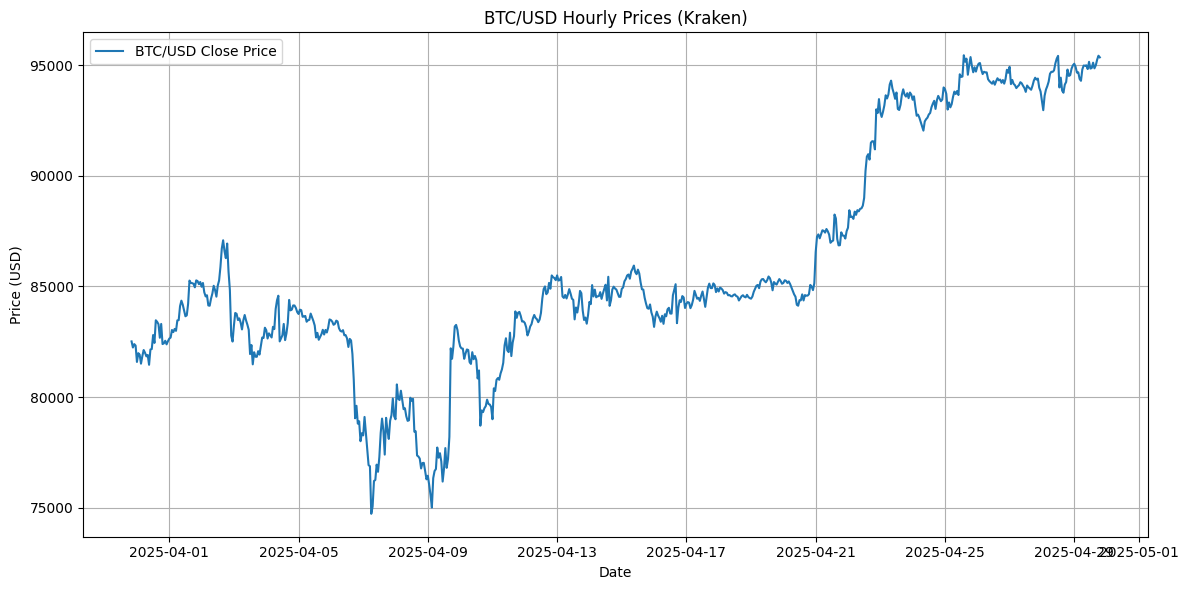

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# If you already saved it earlier:
# df = pd.read_csv('btc_usd_hourly_kraken.csv', index_col='timestamp', parse_dates=True)

# Plotting the closing price over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], label='BTC/USD Close Price')
plt.title('BTC/USD Hourly Prices (Kraken)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## preprocessing.py

1. (do every 30 days) get historical data, last 90 days
2. wavelet transform on a window of 3 days
3. 

In [14]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

def wavelet_denoise(signal, wavelet='db4', level=None, threshold_method='soft'):
    """
    Perform wavelet denoising on a 1D signal.
    
    Parameters:
        signal (array-like): The noisy input signal.
        wavelet (str): Wavelet name (e.g., 'db4', 'haar').
        level (int or None): Decomposition level (defaults to max level).
        threshold_method (str): 'soft' or 'hard' thresholding.
    
    Returns:
        denoised (np.array): The denoised signal.
    """
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))

    denoised_coeffs = [coeffs[0]] + [
        pywt.threshold(c, value=uthresh, mode=threshold_method)
        for c in coeffs[1:]
    ]

    return pywt.waverec(denoised_coeffs, wavelet, mode='per')[:len(signal)]


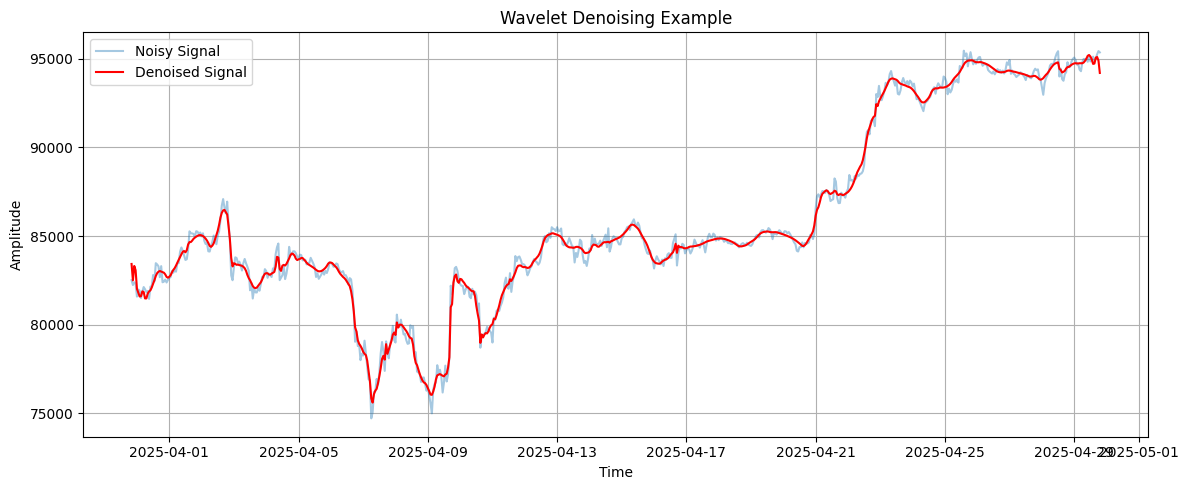

In [15]:
noisy_signal = df['close']
timesteps = df.index

# Apply wavelet denoising
denoised_price = wavelet_denoise(noisy_signal, wavelet='db4', level=4)

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(timesteps, noisy_signal, label='Noisy Signal', alpha=0.4)
plt.plot(timesteps, denoised_price, label='Denoised Signal', color='red')
plt.legend()
plt.title("Wavelet Denoising Example")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
returns = np.log(df['close']).diff().dropna()
window = 100  # number of lags
returns_matrix = np.array([returns.shift(i) for i in range(window)]).T
returns_matrix = returns_matrix[window-1:]  # remove NaNs


from sklearn.preprocessing import StandardScaler

returns_matrix = StandardScaler().fit_transform(returns_matrix)

correlation_matrix = np.corrcoef(returns_matrix, rowvar=False)

In [17]:
from scipy.linalg import eigh

def mp_denoise(corr, q=None):
    n = corr.shape[0]
    T = len(returns_matrix)
    
    if q is None:
        q = T / n
        
    lambda_plus = (1 + (1 / np.sqrt(q))) ** 2  # theoretical maximum eigenvalue

    evals, evecs = eigh(corr)

    # Filter eigenvalues: keep big ones, zero out noise
    cleaned_evals = np.array([e if e > lambda_plus else 0 for e in evals])
    
    # Reconstruct denoised correlation matrix
    cleaned_corr = (evecs @ np.diag(cleaned_evals) @ evecs.T)
    
    # Normalize
    cleaned_corr /= np.outer(np.sqrt(np.diag(cleaned_corr)), np.sqrt(np.diag(cleaned_corr)))
    
    return cleaned_corr

cleaned_corr = mp_denoise(correlation_matrix)



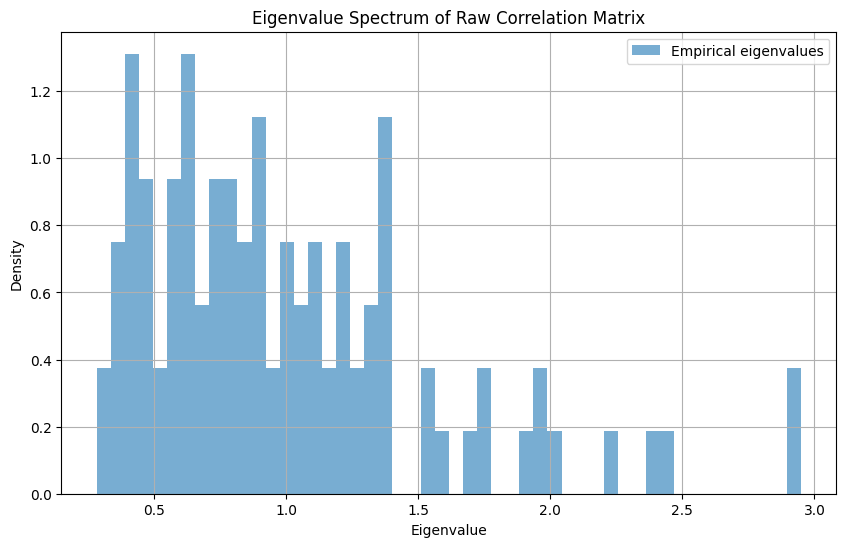

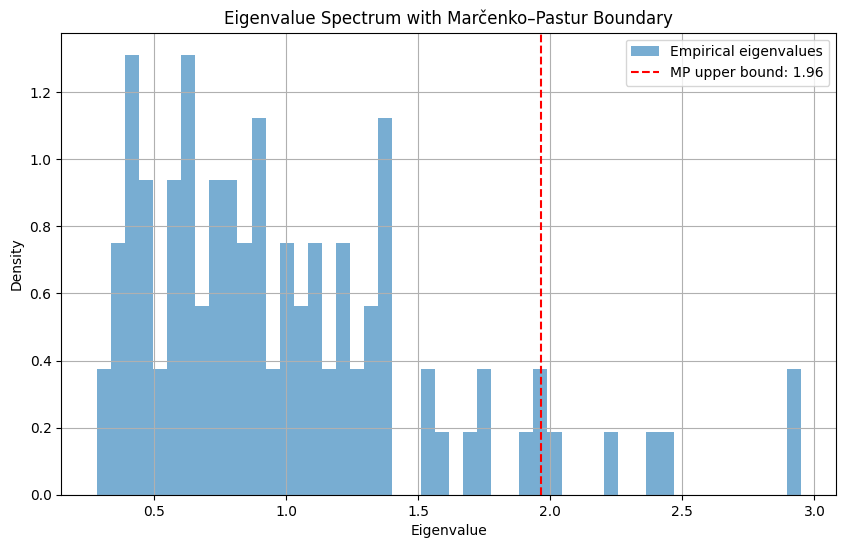

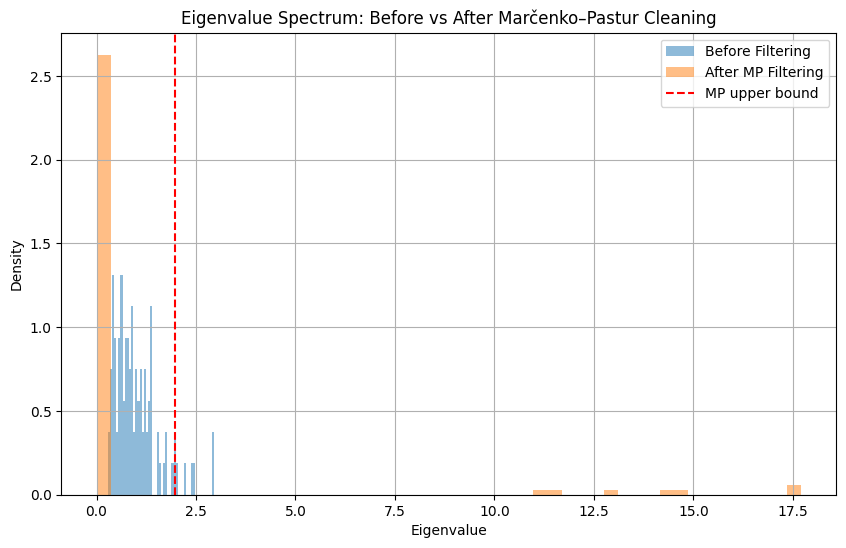

In [18]:
# Eigenvalues of raw correlation matrix
evals_raw, _ = eigh(correlation_matrix)

plt.figure(figsize=(10, 6))
plt.hist(evals_raw, bins=50, density=True, alpha=0.6, label='Empirical eigenvalues')
plt.title("Eigenvalue Spectrum of Raw Correlation Matrix")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

n = correlation_matrix.shape[0]
T = len(returns_matrix)
q = T / n

lambda_plus = (1 + (1/np.sqrt(q)))**2

plt.figure(figsize=(10, 6))
plt.hist(evals_raw, bins=50, density=True, alpha=0.6, label='Empirical eigenvalues')
plt.axvline(lambda_plus, color='red', linestyle='dashed', label=f'MP upper bound: {lambda_plus:.2f}')
plt.title("Eigenvalue Spectrum with Marčenko–Pastur Boundary")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Eigenvalues of cleaned correlation matrix
evals_clean, _ = eigh(cleaned_corr)

plt.figure(figsize=(10, 6))
plt.hist(evals_raw, bins=50, density=True, alpha=0.5, label='Before Filtering')
plt.hist(evals_clean, bins=50, density=True, alpha=0.5, label='After MP Filtering')
plt.axvline(lambda_plus, color='red', linestyle='dashed', label=f'MP upper bound')
plt.title("Eigenvalue Spectrum: Before vs After Marčenko–Pastur Cleaning")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()



In [20]:
import numpy as np
import pandas as pd

def build_features(price_series, window=100):
    df = pd.DataFrame({'price': price_series})
    df['returns'] = df['price'].pct_change()
    
    df['momentum'] = df['price'].diff(window)
    df['volatility'] = df['returns'].rolling(window).std()
    df['sharpe'] = df['returns'].rolling(window).mean() / df['volatility']
    
    # Normalize features
    features = df[['momentum', 'volatility', 'sharpe']].dropna()
    features = (features - features.mean()) / features.std()
    
    return features

def add_eigenvector_features(corr_matrix, top_k=3):
    evals, evecs = eigh(corr_matrix)
    top_vecs = evecs[:, -top_k:]  # top eigenvectors (strongest signals)
    return top_vecs  # shape: (features, top_k)


from sklearn.cluster import KMeans

def cluster_confidence_bins(features, n_bins=5):
    kmeans = KMeans(n_clusters=n_bins, random_state=42)
    labels = kmeans.fit_predict(features)
    
    # Map to confidence bins (1 = low confidence, 5 = strong up)
    cluster_centers = kmeans.cluster_centers_[:, 0]  # use momentum or first PC
    ranking = np.argsort(np.argsort(cluster_centers))
    confidence_bins = np.array([ranking[label] + 1 for label in labels])
    
    return confidence_bins



features = build_features(denoised_price)
confidence_bins = cluster_confidence_bins(features)




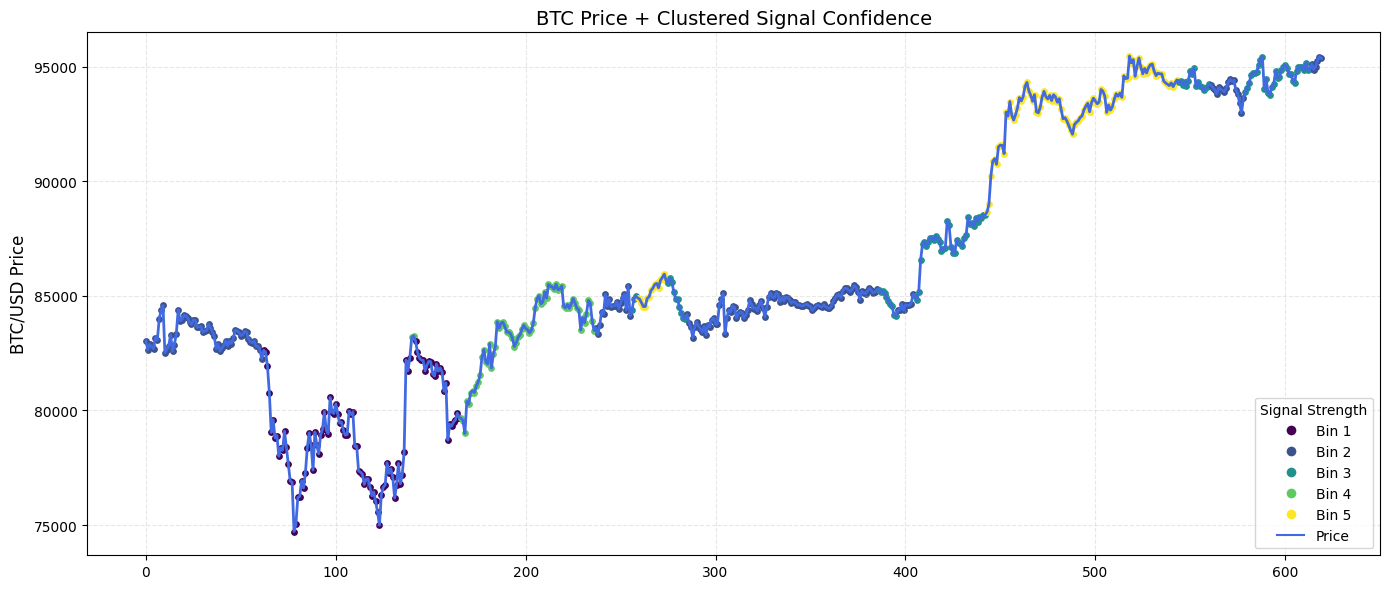

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Assumes `price`, `confidence_bins` already defined

price_trimmed = df['close'][-len(confidence_bins):].values
x = np.arange(len(confidence_bins))

# Normalize bins for color mapping
norm = mcolors.Normalize(vmin=1, vmax=5)
colors = cm.viridis(norm(confidence_bins))

plt.figure(figsize=(14, 6))
ax1 = plt.gca()

# Plot price on left y-axis
ax1.plot(x, price_trimmed, label='Price', color='royalblue', linewidth=2)
ax1.set_ylabel('BTC/USD Price', fontsize=12)
ax1.tick_params(axis='y')
ax1.set_title("BTC Price + Clustered Signal Confidence", fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.3)

# Plot confidence bins as colored dots
for i in range(len(x)):
    ax1.scatter(x[i], price_trimmed[i], color=colors[i], s=15)

# Create custom legend for bins
from matplotlib.lines import Line2D
bin_legend = [Line2D([0], [0], marker='o', color='w', label=f'Bin {i}',
                     markerfacecolor=cm.viridis(norm(i)), markersize=8)
              for i in range(1, 6)]
plt.legend(handles=[*bin_legend, Line2D([], [], color='royalblue', label='Price')], 
           title='Signal Strength', loc='lower right')

plt.tight_layout()
plt.show()
